# Libraries

In [1]:
import numpy as np
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten , BatchNormalization, Conv2D, MaxPooling2D , Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import random
import glob

# Loading Train Data

In [2]:
classes=os.listdir('./training')
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

In [3]:
train_data=[]

for c in classes:
    path=os.path.join('./Training/'+c)
    
    for i in tqdm(glob.glob(path+'/*.jpg')):
        img_array=cv2.imread(i)
        resized_img=cv2.resize(img_array,(224,224))
        train_data.append([resized_img,c])


100%|██████████████████████████████████████████████████████████████████████████████| 1457/1457 [00:21<00:00, 69.19it/s]


In [4]:
random.shuffle(train_data)

In [5]:
X=[]
y=[]

for image ,label in tqdm(train_data,desc='Loading'):
    X.append(image)
    y.append(label)
    

Loading: 100%|█████████████████████████████████████████████████████████████████| 5712/5712 [00:00<00:00, 635015.49it/s]


In [6]:
X=np.array(X)

In [7]:
X=X/255.0

In [8]:
encoder=LabelEncoder()

In [9]:
y = encoder.fit_transform(y)

In [10]:
y=np.array(y)

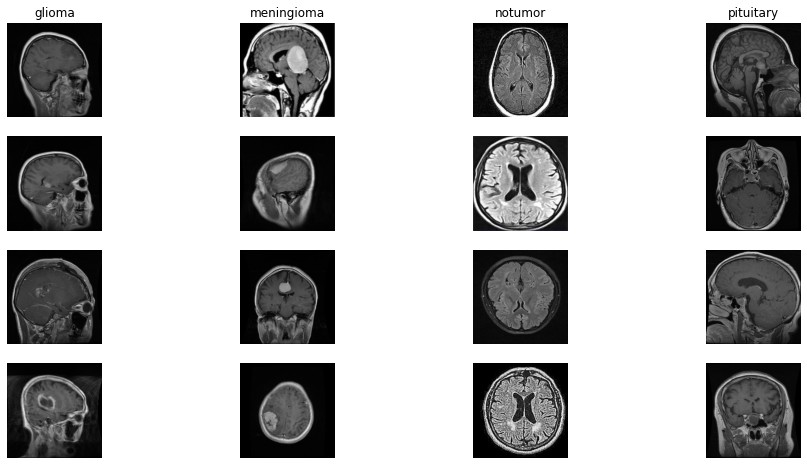

In [11]:
samples_per_class = 4

plt.figure(figsize=(16, 8))

for cls, name in enumerate(classes):
    idxs = np.flatnonzero(y == cls)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(samples_per_class, len(classes), i *len(classes)  + cls + 1)
        plt.imshow(np.float32(X[idx]))
        plt.axis('off')
        if i == 0:
            plt.title(classes[cls])

In [12]:
X=np.float16(X)

# Data Agumentation

In [13]:
img_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

img_datagen.fit(X)

# Creating the Model

In [14]:
def create_cnn():
    model = Sequential()

    # Conv Block 1
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=X.shape[1:], activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Conv Block 2
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Conv Block 3
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Classifier
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(len(classes), activation='softmax'))
    
    return model

model = create_cnn()

#print model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0

In [15]:
model.compile(loss='sparse_categorical_crossentropy',
                    optimizer=Adam(0.001),
                    metrics=['accuracy'])

In [16]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(
    filepath='./',
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    save_freq="epoch",
    options=None,
    initial_value_threshold=None,
)


# Training 

In [17]:
history=model.fit(X,y,epochs=9,validation_split=0.1,verbose=2,callbacks=[model_checkpoint])

Epoch 1/9
161/161 - 3050s - loss: 0.8844 - accuracy: 0.6375 - val_loss: 0.5013 - val_accuracy: 0.8042
Epoch 2/9
161/161 - 2978s - loss: 0.5050 - accuracy: 0.8082 - val_loss: 0.4230 - val_accuracy: 0.8234
Epoch 3/9
161/161 - 2966s - loss: 0.3781 - accuracy: 0.8576 - val_loss: 0.3146 - val_accuracy: 0.8811
Epoch 4/9
161/161 - 2987s - loss: 0.2865 - accuracy: 0.8953 - val_loss: 0.2635 - val_accuracy: 0.9038
Epoch 5/9
161/161 - 2957s - loss: 0.2307 - accuracy: 0.9152 - val_loss: 0.2722 - val_accuracy: 0.9091
Epoch 6/9
161/161 - 2977s - loss: 0.1890 - accuracy: 0.9276 - val_loss: 0.2494 - val_accuracy: 0.9301
Epoch 7/9
161/161 - 2968s - loss: 0.1452 - accuracy: 0.9481 - val_loss: 0.2397 - val_accuracy: 0.9266
Epoch 8/9
161/161 - 2964s - loss: 0.1158 - accuracy: 0.9568 - val_loss: 0.1977 - val_accuracy: 0.9510
Epoch 9/9
161/161 - 2967s - loss: 0.1012 - accuracy: 0.9650 - val_loss: 0.2315 - val_accuracy: 0.9458


In [18]:
hist=pd.DataFrame(history.history)
hist['epoch']=history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
4,0.230691,0.915175,0.272172,0.909091,4
5,0.188953,0.927626,0.249442,0.930070,5
6,0.145187,0.948054,0.239665,0.926573,6
7,0.115782,0.956809,0.197748,0.951049,7
8,0.101209,0.964981,0.231473,0.945804,8


In [19]:
def plot_history(hist: pd.DataFrame) -> None:
    plt.figure(figsize=(8,12))
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'],hist['loss'],label='Train Loss')
    plt.plot(hist['epoch'],hist['val_loss'],label='Validation Loss')
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'],hist['accuracy'],label='Train Accuracy')
    plt.plot(hist['epoch'],hist['val_accuracy'],label='Validation Accuracy')
    plt.legend()
    
    plt.show()
    

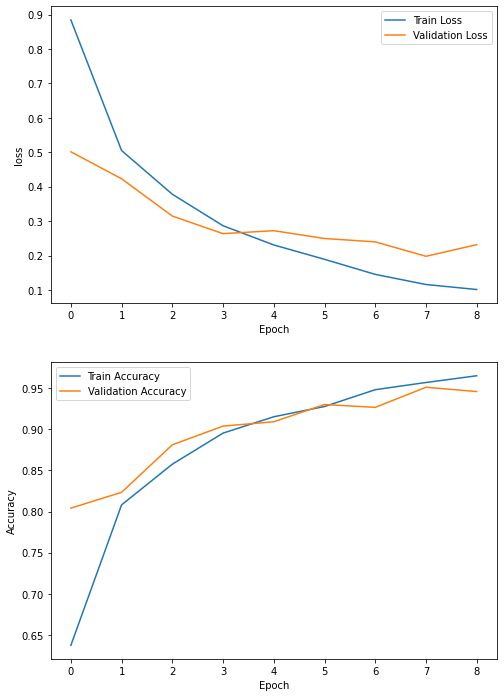

In [20]:
plot_history(hist)

# Loading Test Data

In [21]:
test_data=[]

for c in classes:
    path=os.path.join('./Testing/'+c)
    
    for i in tqdm(glob.glob(path+'/*.jpg')):
        img_array=cv2.imread(i)
        resized_img=cv2.resize(img_array,(224,224))
        test_data.append([resized_img,c])

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:07<00:00, 41.59it/s]


In [22]:
random.shuffle(test_data)

In [23]:
X_test=[]

y_test=[]

for image ,label in tqdm(test_data,desc='Loading'):
    X_test.append(image)
    y_test.append(label)
    

Loading: 100%|█████████████████████████████████████████████████████████████████| 1311/1311 [00:00<00:00, 327598.01it/s]


In [24]:
X_test=np.array(X_test)

In [25]:
X_test=X_test/255.0

In [26]:
y_test = encoder.fit_transform(y_test)

In [27]:
y_test=np.array(y_test)

# Evaluate Test Data

In [28]:
model.evaluate(X_test,y_test,verbose=2)

41/41 - 176s - loss: 0.2117 - accuracy: 0.9451


[0.21174147725105286, 0.9450801014900208]

In [29]:
pred=model.predict(X_test)

In [30]:
y_pred=np.argmax(pred,axis=1)
len(y_pred)

1311

In [31]:
len(y_test)

1311

In [32]:
y_test=np.array(y_test)

In [33]:
C_M=confusion_matrix(y_test,y_pred)
C_M

array([[282,  17,   0,   1],
       [ 24, 259,  12,  11],
       [  2,   1, 400,   2],
       [  0,   2,   0, 298]], dtype=int64)

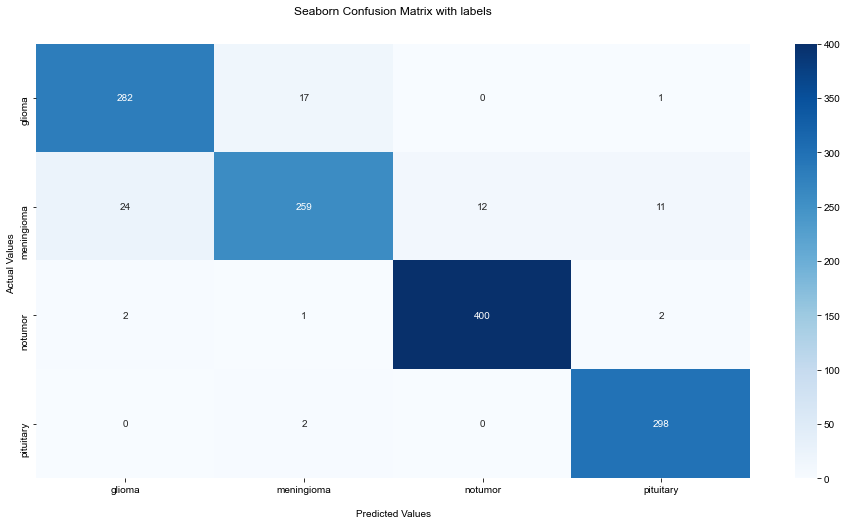

In [34]:
plt.figure(figsize=(16, 8))
ax = sns.heatmap(C_M, annot=True, cmap='Blues',fmt='.5g')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
sns.set(rc = {'figure.figsize':(20,20)})
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(encoder.classes_)
ax.yaxis.set_ticklabels(encoder.classes_)

## Display the visualization of the Confusion Matrix.
plt.show()


In [35]:
idx = np.random.choice(X_test.shape[0], 25, replace=False)
y_pred = model.predict(X_test[idx]).argmax(axis=1)
print(y_pred)
y_true = y_test[idx]
print(y_true)

[2 0 1 2 3 1 3 3 0 0 0 2 1 2 0 0 2 1 2 2 1 2 1 2 0]
[2 0 1 2 3 1 3 3 1 0 0 2 1 2 0 0 2 1 2 2 1 2 0 2 0]


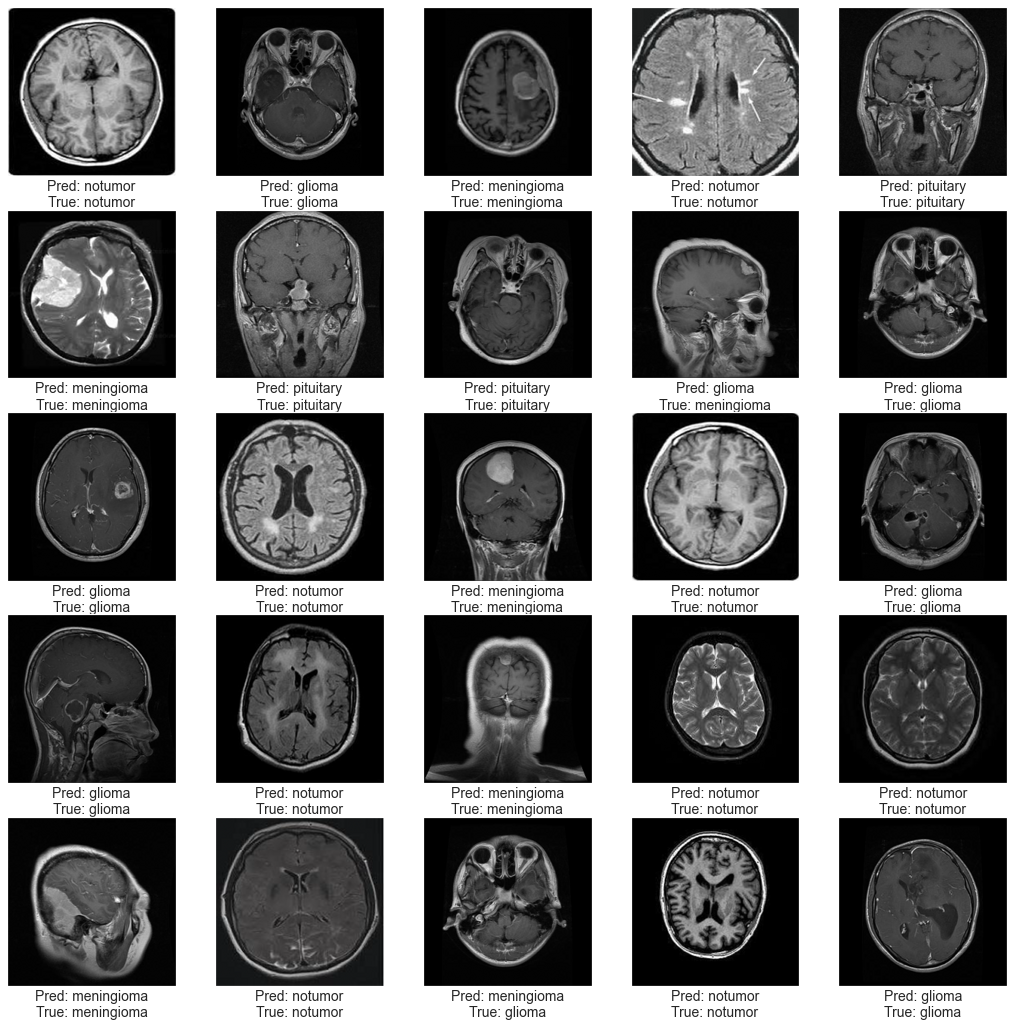

In [36]:
fig, axes = plt.subplots(5, 5, figsize=(18, 18))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[idx[i]].reshape(224, 224, 3), interpolation='spline16')
    pred_class = classes[y_pred[i]]
    true_class = classes[y_true[i]]
    ax.set_xlabel('Pred: {}\nTrue: {}'.format(pred_class, true_class), fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])